In [1]:
import numpy as np
import copy
from numpy import exp, sqrt, pi, sin
import matplotlib.pyplot as plt

from scipy.sparse import diags

%matplotlib inline

## Практическое задание 2. Задача 3

Решить задачу Дирихле в квадрате для уравнения Пуассона с точностью $\epsilon = 10^{-6}$.

$$
\begin{cases}
    \cfrac{\partial^2 u}{\partial x^2} + \cfrac{\partial^2 u}{\partial y^2} = -32\left(x(1-x)+y(1-y)\right)\\
    u|_{x, y \in Г} = 0
\end{cases}
$$

Использовать пятиточечную аппроксимацию оператора Лапласа. Исследовать зависимость числа итераций, обеспечивающих заданную точность, от количества интервалов сетки по одному направлению. Использовать:

* метод Якоби
* метод последовательной верхней релаксации при шахматном упорядочивании с оптимальным параметром

---

### 1 Постановка задачи

Будем использовать схему крест для решения данного уравнения:

$$
\begin{aligned}
\Lambda_{1}y_{mn} + \Lambda_{2}y_{mn} =& f_{mn}\\
\cfrac{y_{m+1,n}-2y_{mn}+y_{m-1,n}}{h_1^2}+\cfrac{y_{m,n+1}-2y_{mn}+y_{m,n-1}}{h_2^2} =& f_{mn}
\end{aligned}
$$

Введем следующие векторные обозначения:

$$
\begin{aligned}
\mathbf{f} &= [f_{11}, f_{12}, \cdots f_{1,n-1}, f_{21}, f_{22}, \cdots, f_{2,n-1}, f_{31}, \cdots, f_{m-1,n-1}]^T\\
\mathbf{y} &= [y_{11}, y_{12}, \cdots y_{1,n-1}, y_{21}, y_{22}, \cdots, y_{2,n-1}, y_{31}, \cdots, y_{m-1,n-1}]^T
\end{aligned}
$$

Тогда оператор производных можно записать следующим образом (для определенности для случая 3x3):

$$
\begin{bmatrix}
    -2/h_1^2-2/h_2^2 & 1/h^2_2 & 0 & 1/h_1^2 & 0 & 0 & 0 & 0 & 0 \\
    1/h^2_2 & -2/h_1^2-2/h_2^2 & 1/h^2_2 & 0 & 1/h_1^2 & 0 & 0 & 0 & 0 \\
    0 & 1/h^2_2 & -2/h_1^2-2/h_2^2 & 1/h^2_2 & 0 & 1/h_1^2 & 0 & 0 & 0 \\
    1/h_1^2 & 0 & 1/h^2_2 & -2/h_1^2-2/h_2^2 & 1/h^2_2 & 0 & 1/h_1^2 & 0 & 0 \\
    0 & 1/h_1^2 & 0 & 1/h^2_2 & -2/h_1^2-2/h_2^2 & 1/h^2_2 & 0 & 1/h_1^2 & 0 \\
    0 & 0 & 1/h_1^2 & 0 & 1/h^2_2 & -2/h_1^2-2/h_2^2 & 1/h^2_2 & 0 & 1/h_1^2 \\
    0 & 0 & 0 & 1/h_1^2 & 0 & 1/h^2_2 & -2/h_1^2-2/h_2^2 & 1/h^2_2 & 0 \\
    0 & 0 & 0 & 0 & 1/h_1^2 & 0 & 1/h^2_2 & -2/h_1^2-2/h_2^2 & 1/h^2_2 \\
    0 & 0 & 0 & 0 & 0 & 1/h_1^2 & 0 & 1/h^2_2 & -2/h_1^2-2/h_2^2 \\
\end{bmatrix}
$$

Заметим, что в силу нулевых граничных условий дополнительных модификаций вносить не требуется (см. задачу 1 и 2 из практического задания 2). Отметим, что матрица всегда будет квадратной вне зависимости от выбранной сетки, а в методичке лектора содержится опечатка.

Таким образом, мы получили следующую систему уравнений с матрицей, определенной выше:

$$
A\mathbf{y} = \mathbf{f}
$$

Введем следующее разбиение:

In [2]:
h1 = 0.5*1e-1
h2 = 0.5*1e-1

h = [h1, h2]

x_m = np.arange(0., 1.+h1, h1)[1:-1]
y_n = np.arange(0., 1.+h2, h2)[1:-1]

m = len(x_m)
n = len(y_n)

Тогда для вектора правых частей:

In [3]:
def func(x_m, y_n):
    m = len(x_m)
    n = len(y_n)
    f = np.array([0.]*(m*n))

    for i in range(m):
        for j in range(n):
            f[n*i+j] = -32.*(x_m[i]*(1.-x_m[i])+y_n[j]*(1.-y_n[j]))
            
    return f

Теперь зададим матрицу $A$. Следует иметь ввиду, что в общем случае $m \neq n$. Смещение по other_diag определяется индексом n:

In [4]:
main_diag  = [-2./h1**2-2./h2**2]*(m*n)
side_diag  = [1./h2**2]*(m*n-1)
other_diag = [1./h1**2]*(m*n-n)

В пособии Аристовой содержится опечатка, матрица A имеет не совсем такой вид:

In [5]:
for i in range(1, m):
    side_diag[i*n - 1] = 0

По условию задачу требуется решить с заданной точностью:

In [26]:
epsilon = 1e-6

Точное решение задачи:

$$
u(x, y) = 16 (x-1) x (y-1) y
$$

In [27]:
def exact(h):
    h1 = h[0]
    h2 = h[1]
    
    x_m = np.arange(0., 1.+h1, h1)[1:-1]
    y_n = np.arange(0., 1.+h2, h2)[1:-1]
    
    m = len(x_m)
    n = len(y_n)
    f = np.array([0.]*(m*n))

    for i in range(m):
        for j in range(n):
            f[n*i+j] = 16*(x_m[i]-1)*x_m[i]*(y_n[j]-1)*y_n[j]
            
    matrix_form = np.zeros((n+2, m+2))
    for i in range(m):
        for j in range(n):
            matrix_form[j+1, i+1] = f[n*i+j]
            
    return matrix_form

### 2 Jacobi

Запишем метод Якоби в покомпонентном виде (матричное представление не подходит, посколько мы явно не формируем матрицы):

$$
\begin{cases}
z_1^{(s+1)} = \cfrac{1}{a_{11}}\left(f_1 - \sum_{j=2}^{n} a_{1j}z_{j}^{(s)}\right)\\ 
\cdots\\
z_i^{(s+1)} = \cfrac{1}{a_{ii}}\left(f_i - \sum_{j=1}^{i-1} a_{ij}z_{j}^{(s)} - \sum_{j=i+1}^{n} a_{ij}z_{j}^{(s)}\right)\\ 
\cdots
\end{cases}
$$

Поскольку матрица разрежена, мы можем упростить эту систему:

$$
\begin{cases}
z_1^{(s+1)} = \cfrac{1}{a_{11}}\left(f_1 - a_{12}z_{2} - a_{1,1+n}z_{1+n} \right)\\ 
\cdots\\
z_i^{(s+1)} = \cfrac{1}{a_{ii}}\left(f_i - a_{i,i-n}z_{i-n} - a_{i,i-1}z_{i-1} - a_{i,i+1}z_{i+1} - a_{i,i+n}z_{i+n}\right)\\ 
\cdots
\end{cases}
$$

Начальное приближение:

In [28]:
initial_guess = np.array([.5]*(m*n))

Реализация (корректно работает при $f = 0$):

In [29]:
def jacobi_solver(h, func, eps, max_iter):
    h1 = h[0]
    h2 = h[1]
    
    x_m = np.arange(0., 1.+h1, h1)[1:-1]
    y_n = np.arange(0., 1.+h2, h2)[1:-1]
    
    m = len(x_m)
    n = len(y_n)
    
    m_d = np.array([-2./h1**2-2./h2**2]*(m*n))
    s_d = np.array([1./h2**2]*(m*n-1))
    o_d = np.array([1./h1**2]*(m*n-n))
    f   = func(x_m, y_n)
    
    for i in range(1, m):
        s_d[i*n - 1] = 0
    
    curr_val = np.array([.5]*(m*n))
    next_val = np.array([.5]*(m*n))
    iterations = 0
    
    
    
    # ------------ main while loop ------------
    while True:
        # first row
        next_val[0] = 1/m_d[0]*(f[0] - s_d[0]*curr_val[1] \
                                     - o_d[0]*curr_val[n])
        
        # first part
        i = np.array(range(1, n))
        next_val[i] = 1/m_d[i]*(f[i] - s_d[i-1]*curr_val[i-1] \
                                     - s_d[i]  *curr_val[i+1] \
                                     - o_d[i]  *curr_val[i+n])
        
        # update middle
        i = np.array(range(n, m*n-n))
        next_val[i] = 1/m_d[i]*(f[i] - o_d[i-n]*curr_val[i-n] \
                                     - s_d[i-1]*curr_val[i-1] \
                                     - s_d[i]  *curr_val[i+1] \
                                     - o_d[i]  *curr_val[i+n])
        
        # update second part
        i = np.array(range(m*n-n, m*n-1))
        next_val[i] = 1/m_d[i]*(f[i] - o_d[i-n]*curr_val[i-n] \
                                     - s_d[i-1]*curr_val[i-1] \
                                     - s_d[i]  *curr_val[i+1])
        
        # last row
        next_val[(m*n-1)] = 1/m_d[(m*n-1)]*(f[(m*n-1)] - o_d[(m*n-1)-n]*curr_val[(m*n-1)-n] \
                                                       - s_d[(m*n-1)-1]*curr_val[(m*n-1)-1])
        
        
        # print(curr_val is next_val)
        # print(curr_val == next_val)
        
        if iterations > max_iter:
            break
            
        if np.linalg.norm(next_val - curr_val) < eps:
            break
            
        curr_val   = copy.copy(next_val)
        iterations = iterations + 1
        
            
        
    # ------------ end of main while loop ------------
        
    # convert to matrix
    matrix_form = np.zeros((n+2, m+2))
    
    for i in range(m):
        for j in range(n):
            matrix_form[j+1, i+1] = curr_val[n*i+j]
            
    # graphics
    extent = [x_m[0]-h1/2, x_m[-1]+h1/2, y_n[0]-h2/2, y_n[-1]+h2/2]
    
    return {'res': matrix_form, 'iter': iterations, 'extent': extent, 'tol': np.linalg.norm(next_val - curr_val)}

Запускаем солвер

In [30]:
jac_solution = jacobi_solver(h=h, func=func, eps=1e-3, max_iter=10000)

In [31]:
jac_solution['iter']

280

In [32]:
jac_solution['tol']

0.0009894602916000433

Строим решение

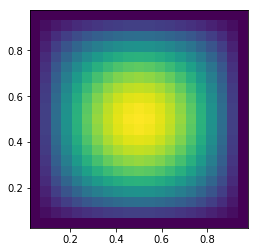

In [33]:
plt.imshow(jac_solution['res'], extent=jac_solution['extent'])

### 4 Точное решение

Полоучим точное решение

In [34]:
#A = diags([other_diag, side_diag, main_diag, side_diag, other_diag], [-n,-1,0,1,n]).toarray()
#f2 = np.linalg.inv(A).dot(func(x_m, y_n))
exact_solution = exact(h=h)

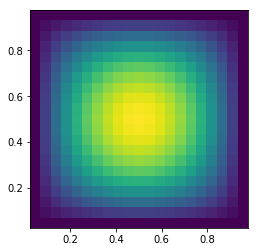

In [35]:
plt.imshow(exact_solution, extent=[x_m[0]-h1/2, x_m[-1]+h1/2, y_n[0]-h2/2, y_n[-1]+h2/2])

### 5 Исследуем порядок аппроксимации

Смотрим на график с ошибками

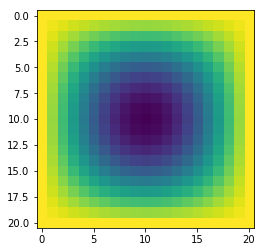

In [36]:
plt.imshow(jac_solution['res'] - exact_solution)

Будем использовать метод сгущающихся сеток для определения порядка аппроксимации. Найдем точное и приближенное на двойной сетке

In [37]:
jac_solution_double = jacobi_solver(h=0.5*np.array(h), func=func, eps=1e-3, max_iter=10000)
exact_solution_double = exact(h=0.5*np.array(h))

Смотрим на ошибки

In [48]:
a = np.linalg.norm(np.array(jac_solution['res']        - exact_solution))
b = np.linalg.norm(np.array(jac_solution_double['res'] - exact_solution_double))

print('Шаг: ', h[0],     '\t Ошибка', a)
print('Шаг: ', 0.5*h[0], '\t Ошибка', b, '\n')
print('Отношение', b/a)

Шаг:  0.05 	 Ошибка 0.08035264435268946
Шаг:  0.025 	 Ошибка 0.32422782206220185 

Отношение 4.035061007315184


Итак, отличие в 4 раза, что подтверждает тот факт, что схема 2-ого порядка аппроксимации.,

### 6 Метод последовательной верхней релаксации

Реализация алгоритма

In [20]:
def sor_solver(h, func, eps, max_iter):
    def mask(m, n):
        a = [True, False]*(int(m/2))+[True]*(m%2)
        b = [not x for x in a]
        black_bool = np.array((a+b)*(int(n/2))+a*(n%2))
        white_bool = np.array([not x for x in black_bool])
        black_ind = np.where(black_bool == True)[0]
        white_ind = np.where(white_bool == True)[0]
        return black_bool, black_ind, white_bool, white_ind
    
    def sor_iter(current, ind):
        old = current
        
        if (0 in ind):
            current[0] = 1/m_d[0]*(f[0] - s_d[0]*current[1] \
                                        - o_d[0]*current[n])
        for i in range(1, n):
            if (i in ind):
                current[i] = 1/m_d[i]*(f[i] - s_d[i-1]*current[i-1] \
                                            - s_d[i]  *current[i+1] \
                                            - o_d[i]  *current[i+n])
        for i in range(n, m*n-n):
            if (i in ind):
                current[i] = 1/m_d[i]*(f[i] - o_d[i-n]*current[i-n] \
                                            - s_d[i-1]*current[i-1] \
                                            - s_d[i]  *current[i+1] \
                                            - o_d[i]  *current[i+n])
        for i in range(m*n-n, m*n-1):
            if (i in ind):
                current[i] = 1/m_d[i]*(f[i] - o_d[i-n]*current[i-n] \
                                            - s_d[i-1]*current[i-1] \
                                            - s_d[i]  *current[i+1])
                
        if (m*n-1 in ind):
            current[m*n-1] = 1/m_d[m*n-1]*(f[m*n-1] - o_d[m*n-1-n]*current[m*n-1-n] \
                                                    - s_d[m*n-1-1]*current[m*n-1-1])
        return old + 1.*(current-old)
    
    h1 = h[0]
    h2 = h[1]
    
    x_m = np.arange(0., 1.+h1, h1)[1:-1]
    y_n = np.arange(0., 1.+h2, h2)[1:-1]
    
    m = len(x_m)
    n = len(y_n)
    
    m_d = np.array([-2./h1**2-2./h2**2]*(m*n))
    s_d = np.array([1./h2**2]*(m*n-1))
    o_d = np.array([1./h1**2]*(m*n-n))
    f   = func(x_m, y_n)
    
    for i in range(1, m):
        s_d[i*n - 1] = 0
    
    curr_val = np.array([.5]*(m*n))
    next_val = np.array([.5]*(m*n))
    iterations = 0
    
    # define mask for chess order
    black_bool, black_ind, white_bool, white_ind = mask(m=m, n=n)
    
    
    # ------------ main while loop ------------
    while True:
        # SOR for black
        next_val[black_ind] = sor_iter(current=next_val, ind=black_ind)[black_ind]
        
        # SOR for white
        next_val[white_ind] = sor_iter(current=next_val, ind=white_ind)[white_ind]
        
        if iterations > max_iter:
            break
            
        if np.linalg.norm(next_val - curr_val) < eps:
            break
            
        curr_val   = copy.copy(next_val)
        iterations = iterations + 1
    # ------------ end of main while loop ------------
        
    
    # convert to matrix
    matrix_form = np.zeros((n+2, m+2))
    
    for i in range(m):
        for j in range(n):
            matrix_form[j+1, i+1] = curr_val[n*i+j]
    
    # graphics
    extent = [x_m[0]-h1/2, x_m[-1]+h1/2, y_n[0]-h2/2, y_n[-1]+h2/2]
    
    return {'res': matrix_form, 'iter': iterations, 'extent': extent}

Запускаем солвер

In [21]:
sor_solution = sor_solver(h=h, func=func, eps=1e-3, max_iter=1000)

In [22]:
sor_solution['iter']

168

Строим

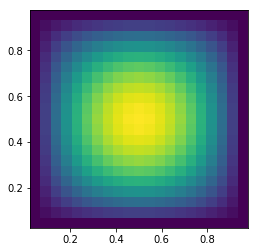

In [23]:
plt.imshow(sor_solution['res'], extent=sor_solution['extent'])

### 5 Несимметричная сетка

In [24]:
jac_solution_n = jacobi_solver(h=[1e-2,1e-1], func=func, eps=epsilon, max_iter=1000)

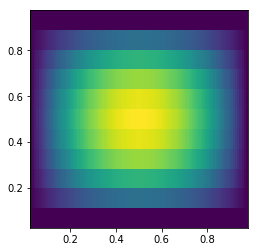

In [25]:
plt.imshow(jac_solution_n['res'], extent=sor_solution['extent'])